In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
#Hyperparamters
BATCH_SIZE = 64

In [4]:
train_transform = transforms.Compose([
        transforms.Resize((64,64)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
        transforms.Resize((64,64)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

In [5]:
class Faces(Dataset):
    def __init__(self, filelist,directory,transform = None):
        self.filelist = filelist
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.filelist[idx]))
        img = img.convert('L')
        img = self.transform(img)
        
        return img
        

In [6]:
train_dir = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
filelist = os.listdir(train_dir)
train_ds = Faces(filelist, train_dir, train_transform)
print(len(train_ds))
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

202599


In [7]:
i = next(iter(train_loader))
print(i.shape)

torch.Size([64, 1, 64, 64])


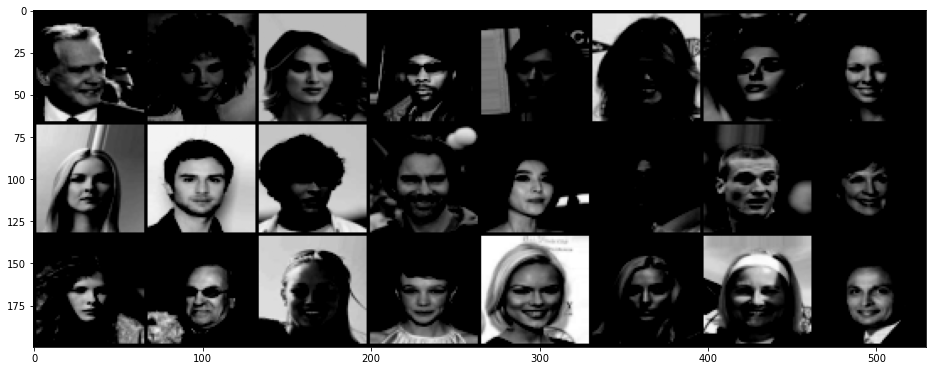

In [8]:
import matplotlib.pyplot as plt
import numpy
samples = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [9]:
class Generator(nn.Module):
    def __init__(self,z_dim,image_dim):
        super(Generator, self).__init__()
        self.deconv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim,image_dim*8,4,1,0))
        self.deconv1_bn = nn.BatchNorm2d(image_dim*8)
        self.deconv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(image_dim*8,image_dim*4, 4, 2, 1))
        self.deconv2_bn = nn.BatchNorm2d(image_dim*4)
        self.deconv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(image_dim*4,image_dim*2, 4, 2, 1))
        self.deconv3_bn = nn.BatchNorm2d(image_dim*2)
        self.deconv4 = nn.utils.spectral_norm(nn.ConvTranspose2d(image_dim*2,image_dim, 4, 2, 1))
        self.deconv4_bn = nn.BatchNorm2d(image_dim)
        self.deconv5 = nn.utils.spectral_norm(nn.ConvTranspose2d(image_dim, 1, 4, 2, 1))

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self,image_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(1, image_dim, 4, 2, 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(image_dim, image_dim*2, 2, 1))
        self.conv2_bn = nn.BatchNorm2d(image_dim*2)
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(image_dim*2,image_dim*4, 4, 2, 1))
        self.conv3_bn = nn.BatchNorm2d(image_dim*4)
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(image_dim*4,image_dim*8, 4, 2, 1))
        self.conv4_bn = nn.BatchNorm2d(image_dim*8)
        self.conv5 = nn.utils.spectral_norm(nn.Conv2d(image_dim*8, 1, 4, 1, 0))

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x

In [10]:
#Define loss functions
#prev lr=2e-3
lr = 8e-4
NUM_EPOCHS = 20
z_dim = 128
image_dim = 64

d = Discriminator(image_dim)
d = d.to(device)

g = Generator(z_dim,image_dim)
g = g.to(device)
criterion = nn.BCELoss()
gen_opt = optim.Adam(g.parameters(), lr = lr)
disc_opt = optim.Adam(d.parameters(), lr = lr)
real_label = 0
fake_label = 1

torch.Size([64, 64])


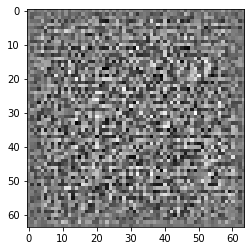

In [11]:
        noise = torch.randn(1,z_dim,1,1).to(device)
        fake = g(noise).detach().cpu()
        img = fake.reshape(64,64)
        img_grid = torchvision.utils.make_grid(fake,normalize = True)
        print(img.shape)
        plt.imshow(img,cmap = "gray")
        plt.show()

100%|██████████| 3166/3166 [37:48<00:00,  1.40it/s, g_loss=0.825]

EPOCH 1 / 20
Running Generator Loss : 1.431558764139008
Running Discriminator Loss : 0.50749454472687
torch.Size([64, 64])


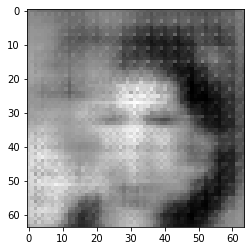

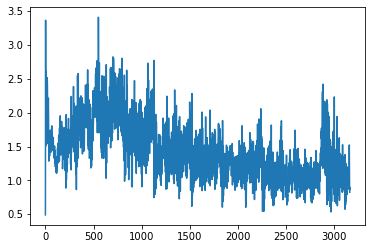

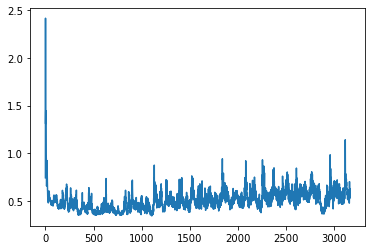

100%|██████████| 3166/3166 [14:55<00:00,  3.54it/s, g_loss=0.784]


EPOCH 2 / 20
Running Generator Loss : 0.9492675880239647
Running Discriminator Loss : 0.6199609794367437
torch.Size([64, 64])


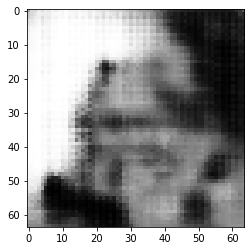

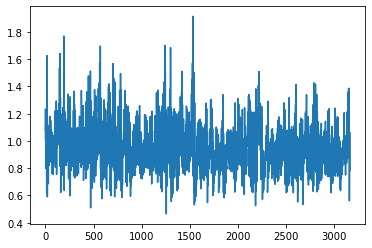

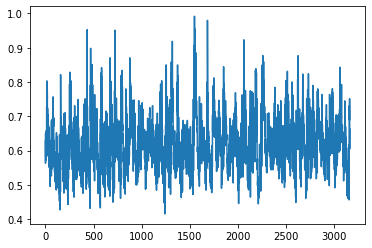

100%|██████████| 3166/3166 [15:10<00:00,  3.48it/s, g_loss=0.89] 


EPOCH 3 / 20
Running Generator Loss : 0.9236730510817249
Running Discriminator Loss : 0.6249208590386416
torch.Size([64, 64])


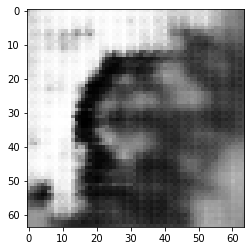

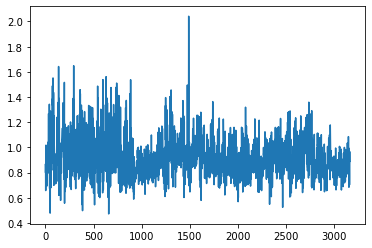

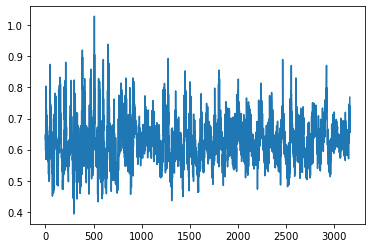

100%|██████████| 3166/3166 [14:56<00:00,  3.53it/s, g_loss=0.787]


EPOCH 4 / 20
Running Generator Loss : 0.8823968548603022
Running Discriminator Loss : 0.637885235066438
torch.Size([64, 64])


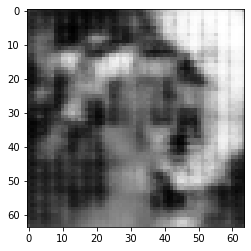

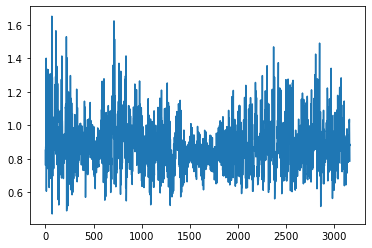

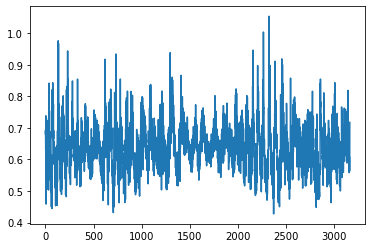

100%|██████████| 3166/3166 [14:38<00:00,  3.61it/s, g_loss=1.37] 


EPOCH 5 / 20
Running Generator Loss : 0.9301373537815755
Running Discriminator Loss : 0.616816679840591
torch.Size([64, 64])


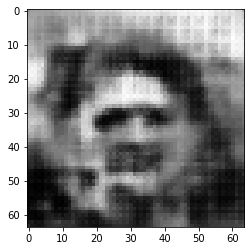

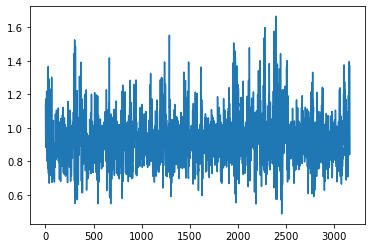

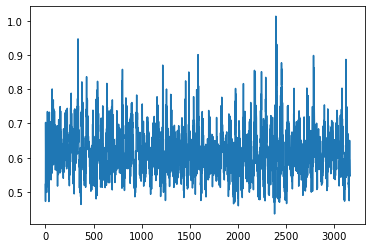

100%|██████████| 3166/3166 [14:32<00:00,  3.63it/s, g_loss=1.25] 


EPOCH 6 / 20
Running Generator Loss : 0.9675553975343253
Running Discriminator Loss : 0.6035690066732339
torch.Size([64, 64])


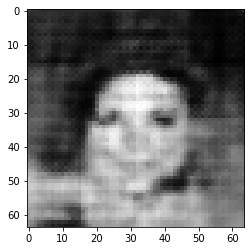

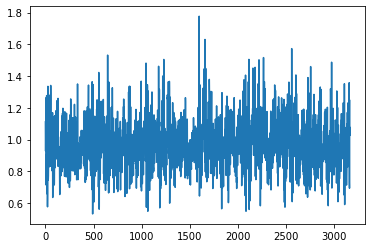

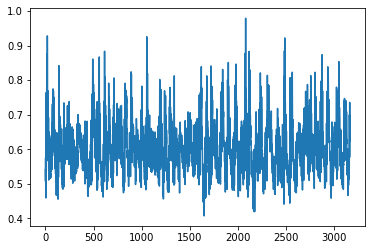

100%|██████████| 3166/3166 [14:42<00:00,  3.59it/s, g_loss=0.878]

EPOCH 7 / 20
Running Generator Loss : 0.9669610010489436
Running Discriminator Loss : 0.6051121846792146
torch.Size([64, 64])


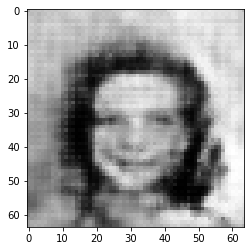

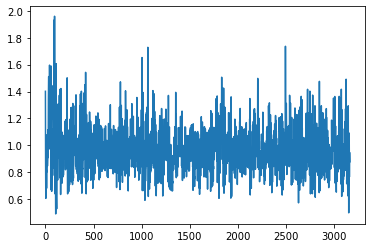

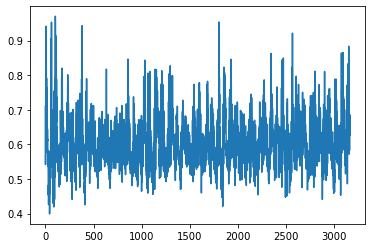

100%|██████████| 3166/3166 [14:33<00:00,  3.62it/s, g_loss=1.18] 


EPOCH 8 / 20
Running Generator Loss : 0.9823926129788443
Running Discriminator Loss : 0.5968309897395229
torch.Size([64, 64])


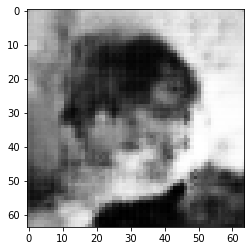

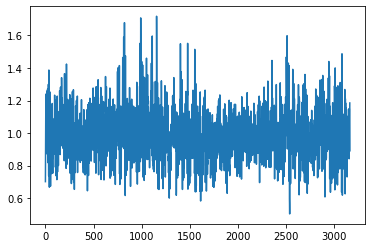

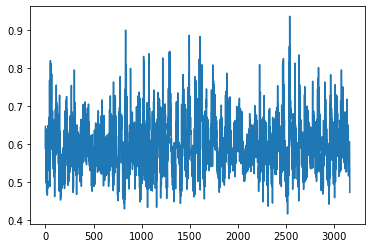

100%|██████████| 3166/3166 [15:12<00:00,  3.47it/s, g_loss=1.01] 

EPOCH 9 / 20
Running Generator Loss : 1.0141358198203847
Running Discriminator Loss : 0.5849962069012286
torch.Size([64, 64])


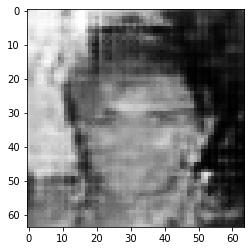

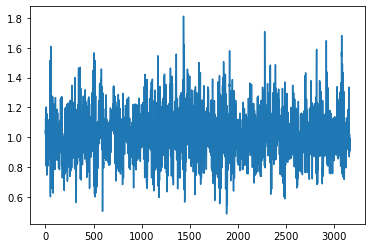

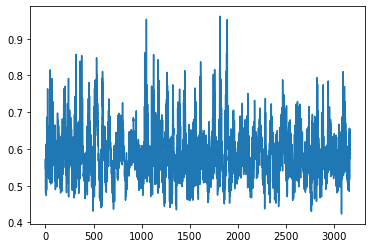

100%|██████████| 3166/3166 [15:13<00:00,  3.47it/s, g_loss=0.925]


EPOCH 10 / 20
Running Generator Loss : 1.03809266425881
Running Discriminator Loss : 0.5773337648702587
torch.Size([64, 64])


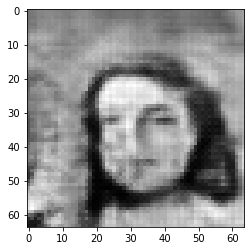

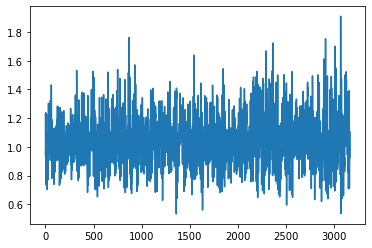

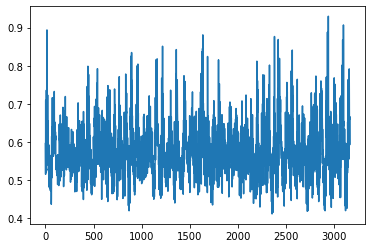

100%|██████████| 3166/3166 [15:02<00:00,  3.51it/s, g_loss=0.982]

EPOCH 11 / 20
Running Generator Loss : 1.0478801270187919
Running Discriminator Loss : 0.5729410019917949
torch.Size([64, 64])


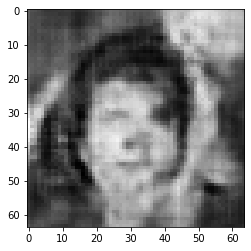

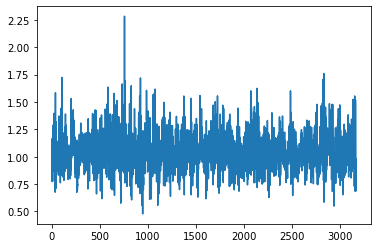

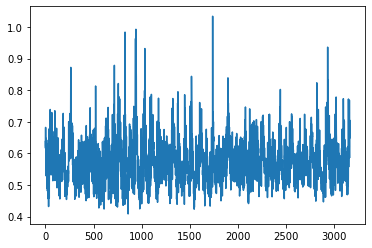

100%|██████████| 3166/3166 [14:38<00:00,  3.60it/s, g_loss=1.24] 


EPOCH 12 / 20
Running Generator Loss : 1.0626809193187323
Running Discriminator Loss : 0.5685647106291144
torch.Size([64, 64])


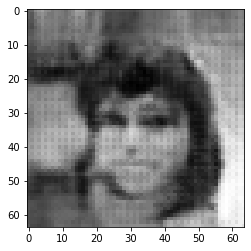

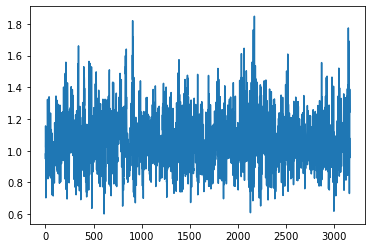

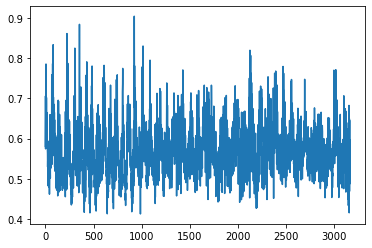

100%|██████████| 3166/3166 [14:32<00:00,  3.63it/s, g_loss=0.887]


EPOCH 13 / 20
Running Generator Loss : 1.0729497567769928
Running Discriminator Loss : 0.566091855426642
torch.Size([64, 64])


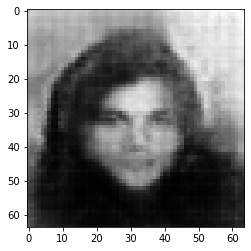

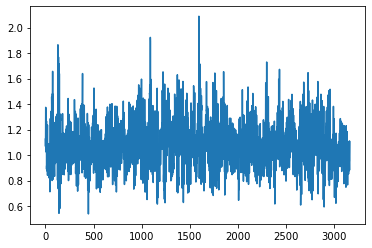

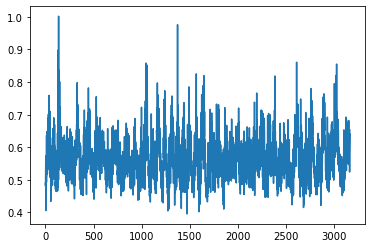

100%|██████████| 3166/3166 [14:41<00:00,  3.59it/s, g_loss=1.06] 


EPOCH 14 / 20
Running Generator Loss : 1.1031708272476402
Running Discriminator Loss : 0.5547409767281459
torch.Size([64, 64])


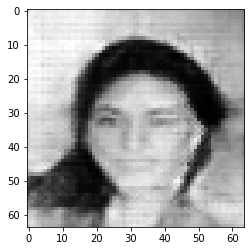

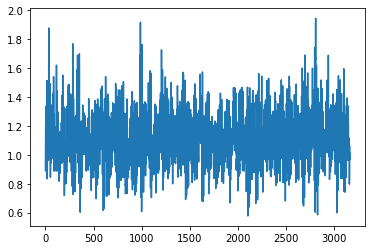

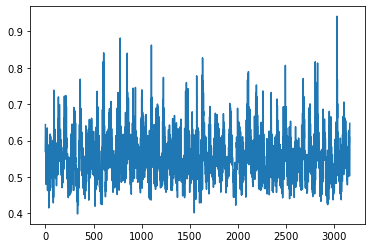

100%|██████████| 3166/3166 [14:47<00:00,  3.57it/s, g_loss=1.01] 


EPOCH 15 / 20
Running Generator Loss : 1.1461182582702203
Running Discriminator Loss : 0.5387676041843916
torch.Size([64, 64])


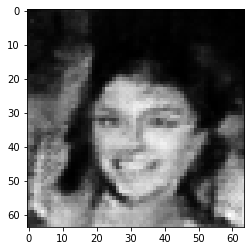

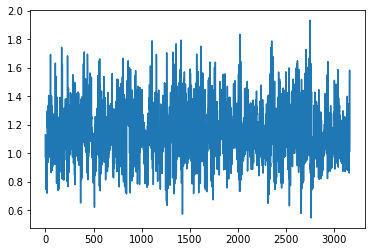

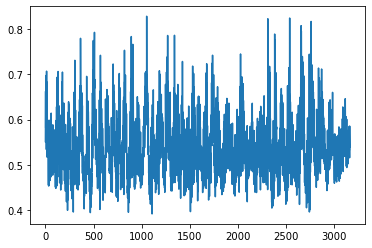

100%|██████████| 3166/3166 [14:56<00:00,  3.53it/s, g_loss=1.3]  

EPOCH 16 / 20
Running Generator Loss : 1.2078979993386127
Running Discriminator Loss : 0.5147647940973202
torch.Size([64, 64])


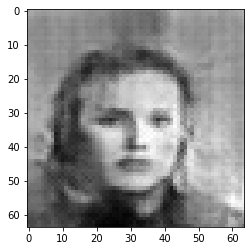

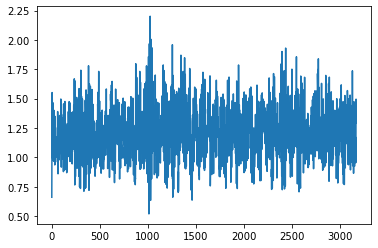

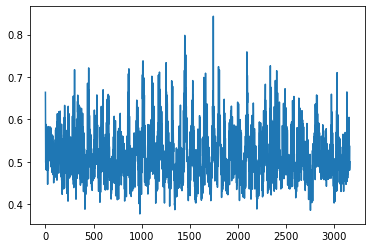

100%|██████████| 3166/3166 [15:09<00:00,  3.48it/s, g_loss=1.48] 


EPOCH 17 / 20
Running Generator Loss : 1.2743062701921108
Running Discriminator Loss : 0.4942306683022842
torch.Size([64, 64])


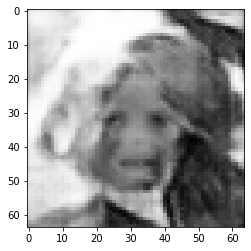

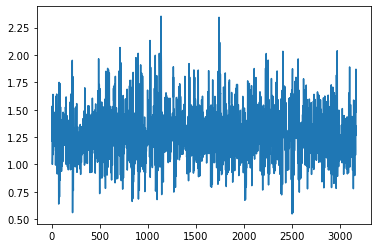

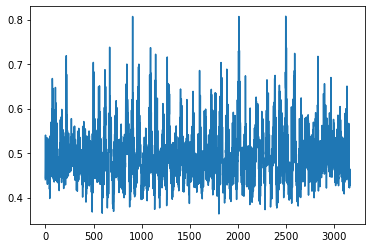

100%|██████████| 3166/3166 [15:02<00:00,  3.51it/s, g_loss=1.44] 


EPOCH 18 / 20
Running Generator Loss : 1.34006027750252
Running Discriminator Loss : 0.47131232464531897
torch.Size([64, 64])


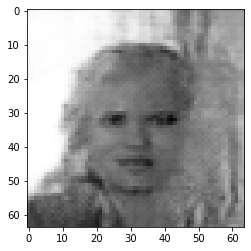

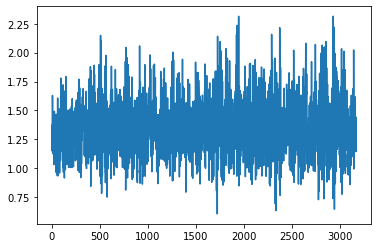

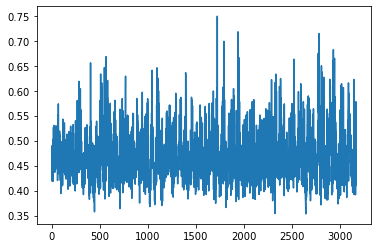

100%|██████████| 3166/3166 [14:31<00:00,  3.63it/s, g_loss=1.44] 


EPOCH 19 / 20
Running Generator Loss : 1.3799778764487367
Running Discriminator Loss : 0.4621566744051775
torch.Size([64, 64])


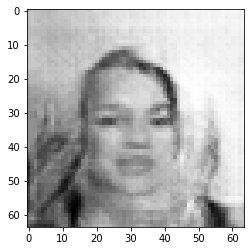

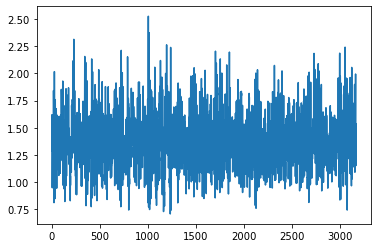

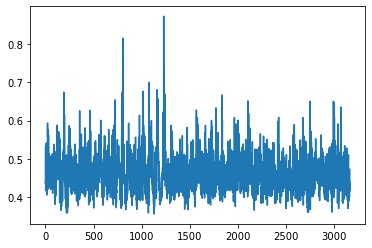

100%|██████████| 3166/3166 [14:52<00:00,  3.55it/s, g_loss=1.93] 


EPOCH 20 / 20
Running Generator Loss : 1.434623382886753
Running Discriminator Loss : 0.4502142678595613
torch.Size([64, 64])


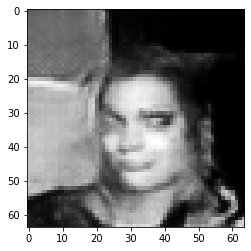

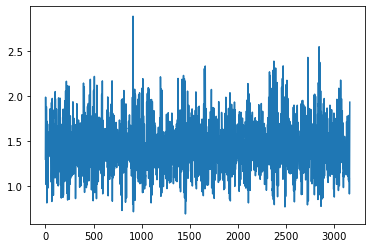

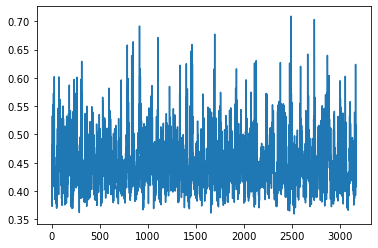

In [12]:
#Train

from tqdm import tqdm
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
    running_g_loss = 0
    running_d_loss =0
    gen_history = []
    disc_history = []
    g.train()
    d.train()
    loop = tqdm(train_loader)
    for idx, (real_image) in enumerate(loop):
        noise = torch.randn(real_image.size(0), z_dim,1,1).to(device)
        #Add decaying random noise
        decaying_noise = torch.randn(real_image.size(0),1,image_dim,image_dim).to(device)*(0.9**epoch)
        decaying_noise_ = torch.randn(real_image.size(0),1,image_dim,image_dim).to(device)*(0.9**epoch)
        real_image = (real_image).to(device)
        real_image = real_image + decaying_noise
        fake_image = g(noise)+decaying_noise_
        d_fake = d(fake_image).view(-1)
        d_real = d(real_image).view(-1)
        #forward pass
        #Swap the label for discriminator and generator
        disc_loss1 = criterion(d_real, torch.ones_like(d_real)*0.9)
        disc_loss2 = criterion(d_fake, torch.ones_like(d_fake)*0.1)
        disc_loss = (disc_loss1+disc_loss2)/2
        
        #backward
        
        disc_opt.zero_grad() 
        scaler.scale(disc_loss).backward(retain_graph = True) #Need to make retain_graph as true if we are reusing computation
        scaler.step(disc_opt)
        scaler.update()
        loop.set_postfix(d_loss = disc_loss.item())
        
        out = d(fake_image).view(-1)
        gen_loss = criterion(out, torch.ones_like(out)*0.9)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
        gen_opt.zero_grad()
        scaler.scale(gen_loss).backward()
        scaler.step(gen_opt)
        scaler.update()
        loop.set_postfix(g_loss = gen_loss.item())
        
        running_g_loss += gen_loss.item()
        running_d_loss += disc_loss.item()
        gen_history.append(gen_loss.item())
        disc_history.append(disc_loss.item())
    
    print("EPOCH",epoch+1,"/",NUM_EPOCHS)
    print("Running Generator Loss :", running_g_loss/3166)
    print("Running Discriminator Loss :", running_d_loss/3166)
    g.eval()
    noise = torch.randn(1,z_dim,1,1).to(device)
    fake = g(noise).detach().cpu()
    #mg = np.transpose(mid_training,(1,2,0))
    with torch.no_grad():
        img = fake.reshape(64,64)
        img_grid = torchvision.utils.make_grid(fake,normalize = True)
        print(img.shape)
        plt.imshow(img,cmap = "gray")
        plt.show()
        
        plt.plot(gen_history)
        plt.show()
        plt.plot(disc_history)
        plt.show()

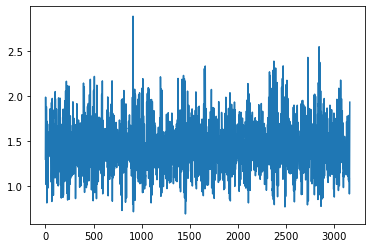

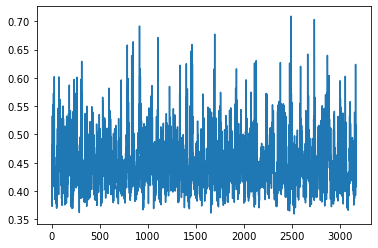

In [13]:
plt.plot(gen_history)
plt.show()
plt.plot(disc_history)
plt.show()

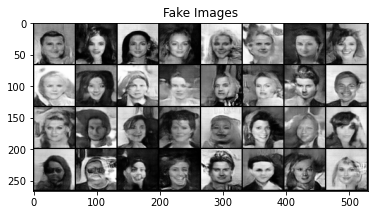

In [29]:
n = torch.randn(BATCH_SIZE, z_dim, 1, 1).to(device)
f = g(n).cpu().detach()
plt.title("Fake Images")
img_grid = torchvision.utils.make_grid(f[0:32],normalize = True)
plt.imshow(np.transpose(img_grid,(1,2,0)))

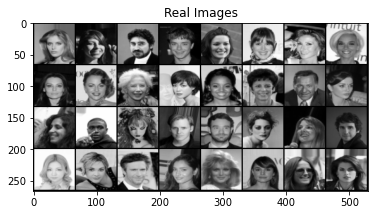

In [30]:
real = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(real[0:32],normalize = True)
plt.title("Real Images")
plt.imshow(np.transpose(img_grid,(1,2,0)))


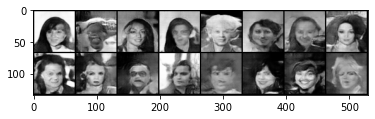

In [21]:
n1 = torch.randn(BATCH_SIZE, z_dim, 1, 1).to(device)
f1 = g(n1).cpu().detach()

img_grid = torchvision.utils.make_grid(f1[0:16],normalize = True)
plt.imshow(np.transpose(img_grid,(1,2,0)))

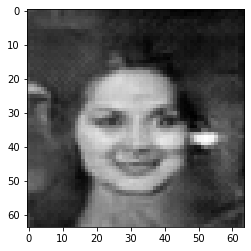

In [19]:
n1 = torch.randn(BATCH_SIZE, z_dim, 1, 1).to(device)
f1 = g(n1).cpu().detach()

img_grid = torchvision.utils.make_grid(f1[5],normalize = True)
plt.imshow(np.transpose(img_grid,(1,2,0)))

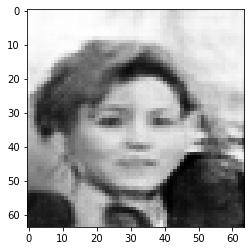

In [20]:
n1 = torch.randn(BATCH_SIZE, z_dim, 1, 1).to(device)
f1 = g(n1).cpu().detach()

img_grid = torchvision.utils.make_grid(f1[12],normalize = True)
plt.imshow(np.transpose(img_grid,(1,2,0)))

In [16]:
model_save_name = 'Faces_SNGAN_Generator.pt'
path = F".//{model_save_name}" 
torch.save(g.state_dict(), path)

In [17]:
model_save_name = 'Faces_SNGAN_Discriminator.pt'
path = F".//{model_save_name}" 
torch.save(d.state_dict(), path)